# Analyse von Einkäufe, um Profit zu finden

In [41]:
# Cell 1: Installieren wir alle nötige Pakete
!pip install numpy pandas scikit-learn catboost lightgbm xgboost


---

## 1. Importieren von Bibliotheken

In [42]:
# Cell 2: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor

---

## 2. Daten laden & Überblick

Wir lesen die CSV ein und verschaffen uns einen schnellen Überblick über Struktur und Datentypen.


In [43]:
# Cell 3: Daten laden und erster Blick
df = pd.read_csv('/content/Sample - Superstore.csv', encoding='latin1', engine='python')
display(df.head())
print(df.info())

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

---

## 3. Feature Engineering

Wir erzeugen neue Merkmale aus Datum, berechnen Versanddauer, rolling-Features und Kreuzmerkmale.


In [44]:
# Cell 4: Feature Engineering
# Datum umwandeln
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')
df['Ship Date']  = pd.to_datetime(df['Ship Date'],  dayfirst=True, errors='coerce')
df = df.dropna(subset=['Order Date','Ship Date'])

# Datumsmerkmale
df['Order_Month']   = df['Order Date'].dt.month
df['Order_Quarter'] = df['Order Date'].dt.quarter
df['Order_Weekday'] = df['Order Date'].dt.weekday  # 0 = Montag

# Versanddauer
df['Shipping_Duration'] = (df['Ship Date'] - df['Order Date']).dt.days

# Rollender Durchschnitt des Profit der letzten 5 Bestellungen pro Kunde
df = df.sort_values(['Customer ID','Order Date'])
df['Customer_Profit_MA5'] = (
    df.groupby('Customer ID')['Profit']
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
)

# Kreuzmerkmal Region × Kategorie
df['Region_Category'] = df['Region'] + '_' + df['Category']


---

## 4. Ausreißerbehandlung

Clippen starker Ausreißer im Profit auf das 1. und 99. Perzentil.


In [45]:
# Cell 5: Ausreißer clippen
lower, upper = np.percentile(df['Profit'], [1, 99])
df['Profit_Capped'] = df['Profit'].clip(lower=lower, upper=upper)

---

## 5. Vorbereitung der Daten

Definition von X und y, Entfernen irrelevanter Spalten und Aufteilung in Trainings- und Testdaten.


In [46]:
# Cell 6: X, y und Train/Test-Split
y = df['Profit_Capped'].values

drop_cols = [
    'Row ID','Order ID','Customer ID','Customer Name',
    'Product ID','Product Name','Order Date','Ship Date',
    'Profit','Profit_Capped'
]
X = df.drop(columns=drop_cols)

numeric_features = [
    'Sales','Quantity','Discount',
    'Order_Month','Order_Quarter','Order_Weekday',
    'Shipping_Duration','Customer_Profit_MA5'
]
categorical_features = [
    'Ship Mode','Segment','Country','City','State',
    'Postal Code','Region','Category','Sub-Category','Region_Category'
]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
print("Train-Shape:", X_train.shape, "Test-Shape:", X_test.shape)


Train-Shape: (2054, 18) Test-Shape: (685, 18)


---

## 6. Einzelne Modelle trainieren und evaluieren

Wir trainieren CatBoost, LightGBM und XGBoost separat und vergleichen RMSE & R².


In [47]:
# Cell 7: Abschließendes Modelltraining & Stacking (funktioniert ohne NaN-Fehler)



# 1) Preprocessing: fehlende Werte auffüllen und One-Hot-Encoding
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='constant', fill_value=0), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# 2) Modelle definieren
rf  = RandomForestRegressor(n_estimators=100, random_state=42)
hgb = HistGradientBoostingRegressor(max_iter=500, learning_rate=0.05, random_state=42)
xgb = XGBRegressor(objective='reg:squarederror', learning_rate=0.05,
                   max_depth=6, n_estimators=500, random_state=42, verbosity=0)
cb  = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6,
                        loss_function='RMSE', eval_metric='RMSE',
                        random_seed=42, verbose=False)

models = [
    ('RandomForest', rf),
    ('HistGB', hgb),
    ('XGBoost', xgb),
    ('CatBoost', cb)
]

# 3) Einzelmodelle trainieren, evaluieren und CV-Vorhersagen sammeln
train_preds = []
test_preds  = []
for name, model in models:
    model.fit(X_train_proc, y_train)
    y_pred_test = model.predict(X_test_proc)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2   = r2_score(y_test, y_pred_test)
    print(f"{name}: RMSE = {rmse:.2f}, R² = {r2:.3f}")
    # CV-Predictions auf Trainingsdaten
    cv_pred = cross_val_predict(model, X_train_proc, y_train, cv=5, method='predict')
    train_preds.append(cv_pred)
    test_preds.append(y_pred_test)

# 4) Ensemble-Stacking mit Ridge
stacked_train = np.column_stack(train_preds)
stacked_test  = np.column_stack(test_preds)

meta = Ridge(alpha=1.0)
meta.fit(stacked_train, y_train)
y_pred_stack = meta.predict(stacked_test)

rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack   = r2_score(y_test, y_pred_stack)
print(f"STACKING: RMSE = {rmse_stack:.2f}, R² = {r2_stack:.3f}")


RandomForest: RMSE = 42.35, R² = 0.807
HistGB: RMSE = 44.88, R² = 0.783
XGBoost: RMSE = 38.82, R² = 0.837
CatBoost: RMSE = 37.34, R² = 0.850
STACKING: RMSE = 38.63, R² = 0.839


---

## 7. Ensemble-Stacking

Wir verwenden die Vorhersagen der drei Basis-Modelle als Features für ein Ridge-Meta-Modell.


In [ ]:
# Cell 8: Stacking mit Ridge (auf vollständig vorverarbeiteten Daten)

# 1) CV-Vorhersagen auf Trainingsdaten
cv_rf  = cross_val_predict(rf,  X_train_proc, y_train, cv=5)
cv_hgb = cross_val_predict(hgb, X_train_proc, y_train, cv=5)
cv_xgb = cross_val_predict(xgb, X_train_proc, y_train, cv=5)
cv_cb  = cross_val_predict(cb,  X_train_proc, y_train, cv=5)

# 2) Vorhersagen auf Testdaten
test_rf  = rf.predict(X_test_proc)
test_hgb = hgb.predict(X_test_proc)
test_xgb = xgb.predict(X_test_proc)
test_cb  = cb.predict(X_test_proc)

# 3) Stacking-Features zusammenfügen
stacked_train = np.column_stack([cv_rf, cv_hgb, cv_xgb, cv_cb])
stacked_test  = np.column_stack([test_rf, test_hgb, test_xgb, test_cb])

# 4) Meta-Modell trainieren und evaluieren
meta = Ridge(alpha=1.0)
meta.fit(stacked_train, y_train)
y_pred_stack = meta.predict(stacked_test)

rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack   = r2_score(y_test, y_pred_stack)
print(f"STACKING → RMSE = {rmse_stack:.2f}, R² = {r2_stack:.3f}")


STACKING → RMSE = 38.63, R² = 0.839


---

## 8. Feature-Importances des CatBoost-Modells

Wir zeigen die Top-10 wichtigsten Merkmale.


,Feature Id,Importances
0,Sales,52.277450
1,Discount,28.601963
2,Sub-Category,8.341799
3,State,3.268893
4,Category,2.671010
5,Region_Category,1.651257
6,Quantity,1.256267
7,Region,0.571275
8,Segment,0.469228
9,Ship Mode,0.307194


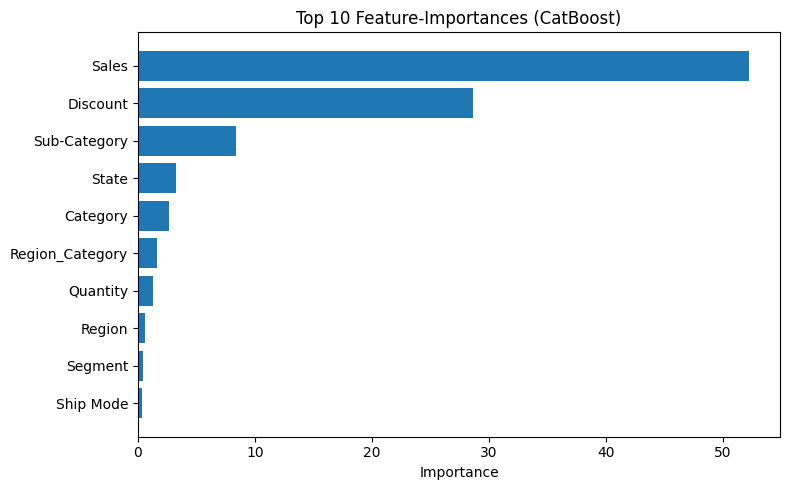

In [49]:
# Cell 9: Importances
imp = cat.get_feature_importance(prettified=True)
display(imp.head(10))

plt.figure(figsize=(8,5))
plt.barh(imp['Feature Id'].head(10), imp['Importances'].head(10))
plt.gca().invert_yaxis()
plt.title('Top 10 Feature-Importances (CatBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()